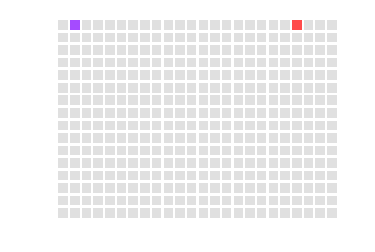

In [177]:
import random
from functools import *
from operator import mul
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.path as mpath
import matplotlib.lines as mlines
import matplotlib.patches as mpatches
from matplotlib.collections import PatchCollection
import math





edges = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,\
             24,47,48,71,72,95,96,119,120,143,144,167,168,191,192,215,216,\
             239,240,263,264,287,288,311,312,335,336,359,\
             360,361,362,363,364,365,366,367,368,369,370,371,\
             372,373,374,375,376,377,378,379,380,381,382,383,384]
topbottom= [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,\
             360,361,362,363,364,365,366,367,368,369,370,371,\
             372,373,374,375,376,377,378,379,380,381,382,383]

def drawPlate(welldict={}):
    fig, ax = plt.subplots()
    # create 3x3 grid to plot the artists
    grid = np.mgrid[0:1:24j,.7:0:16j].reshape(2, -1,order="F").T

    patches = []
    numconstructs=len(set([welldict[a] for a in welldict]))
    #print(numconstructs)
    colrange=np.linspace(0,1,numconstructs)
    random.shuffle(colrange)
    colors=plt.cm.rainbow([0]+colrange)
    
    condiv=0
    #if(constructs>0):
        #condiv=int(384/constructs)
    # add a rectangle
    color=colrange[0]
    #print(len(colors))
    clist=[]
    for a in range(384):
        try:
            color= colors[welldict[a]]
            
        except KeyError:
            color="lightgray"
        rect = mpatches.Rectangle(grid[a], .6/17, 1/28, ec="none", fc=color,alpha=.7)
        plt.gca().add_patch(rect)
        #patches.append(rect)
    #label(grid[1], "Rectangle")
    
    #colors = np.linspace(0, 1, len(patches))
    collection = PatchCollection(patches,alpha=.3)
    #collection.set_array(np.array(colors))
    #ax.add_collection(collection)
    #ax.add_line(line)

    plt.axis('equal')
    #plt.xlim([0,1.2])
    #plt.ylim([0,.8])
    plt.axis('off')
    #plt.tight_layout()

    plt.show()
drawPlate({1:0,20:1})

def allcomb(listoflists):
    """creates all paths through a list"""
    if(len(listoflists)==1):
        return([[a] for a in listoflists[0]])
    outlist = []
    for element in listoflists[0]:
        for lists in allcomb(listoflists[1:]):
            outlist+=[[element]+lists]
    return outlist

def makeGridFile(inducers,wells,construct,fname,blacklist=[],constructnames = [],inducernames=[],shuffle=False,wellorder="across",draw=True):
    outfile = "Source Plate Name,Source Plate Type,Source Well,    Sample ID,Sample Name,Sample Group,Sample Comment,Destination Plate Name,    Destination Well,Transfer Volume\n"
    suppfile = "Well,Construct,"
    suppfile+= ",".join(inducernames)
    suppfile+= "\n"

    eachline = "Source[1],384PP_AQ_BP,{},,,,,Destination[1],{},{}\n"
    rows = "ABCDEFGHIJKLMNOP"

    columns = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24]
    wellslist=range(384)
    if(wellorder=="down"):
        wellslist=list(list(np.reshape(np.reshape(wellslist,(16,24)),(1,-1),order="F"))[0])
    wellsused = []
    wellct = 0
    wlist={}
    for con in construct:
        curconname = constructnames[construct.index(con)]
        wellct = rows.index(con[0])*len(columns)+columns.index(int(con[1:])) #this starts the
        #print(wellct)
        #print(wellslist)
        
        wellind = wellslist.index(wellct)
        
        #well counter at the right row, in the leftmost column
        #if(wellorder=="down"):
        #    wellct = rows.index(con[0])*len(columns)+columns.index(int(con[1:]))
        acomb = allcomb(inducers)
        
        if(shuffle):
            random.shuffle(acomb)
        #print(acomb[:15])
        iterct = reduce(mul,[len(a) for a in inducers],1) #this is the number of wells per construct
        lensum = sum([len(a) for a in inducers])
        ict2 = 0
        conwells=[]
        for iteration in acomb:
            while(wellslist[wellind] in blacklist):
                wellind+=1#moves over the current well if it is in the blacklist
            wellct=wellslist[wellind]
            colct = wellct%len(columns) #deciphering the well number to column and rows
            rowct = int(wellct/len(columns))
            wellstr = rows[rowct]+str(columns[colct])
            #print(iteration)
            suppfile+= ",".join([wellstr,curconname]+[str(a) for a in iteration])+"\n"

            #each comination of volumes is a list
            #where each element corresponds to an inducer
            for ind_i in range(len(iteration)):


                #print(rowct)
                #print(colct)

                if(iteration[ind_i]>0):
                    #don't tell the echo to pipet zero nl!
                    indname = inducernames[ind_i]

                    usewell = wells[ind_i]
                    if(type(usewell)==list):
                        usewell = random.choice(usewell)
                    outfile += eachline.format(usewell,wellstr,iteration[ind_i])
                    wellsused+=[wellct]
                    conwells+=[wellct]
                    wlist.update({wellct:construct.index(con)})
                    
            wellind+=1#here is where we just go along left to right, top to bottom
        #wlist+=[conwells]
    if(draw):
        drawPlate(wlist)
    outfle = open(fname,"w")
    outfle.write(outfile)
    outfle.close()
    supfleout= open("supp_"+fname,"w")
    supfleout.write(suppfile)
    supfleout.close()
    print("done!")
    return wellsused
def makeGridWrapper(inducers,constructs,fname,avoidedges=[],maxinducer=500,wellvol=50,shuffle=False,wellorder="across"):
    if(avoidedges==edges):
        start="B2"
        rows=14
        cols=22
    elif(avoidedges==topbottom):
        start="B1"
        rows=14
        cols=24
    else:
        start="A1"
        rows=16
        cols=24
    #divideplate=int(rows/len(constructs))
    conwells=[]
    if(wellorder=="across"):
        divideplate=math.ceil(rows/len(constructs))
        while(divideplate*len(constructs)>rows):
            divideplate-=1
        for i in range(len(constructs)):
            conwells+=[chr(ord(start[0])+divideplate*i)+start[1:]]
    else:
        divideplate=math.ceil(cols/len(constructs))
        while(divideplate*len(constructs)>cols):
            divideplate-=1
        for i in range(len(constructs)):
            conwells+=[start[0]+str(int(start[1:])+divideplate*i)]
    #print(rows/len(constructs))
    
    
    indonly=[a[0] for a in inducers]
    volonly=[[int(b*maxinducer/100) for b in a[1]] for a in inducers]
    sourceonly=[]
    for src in [a[2] for a in inducers]:
        allwells=[]
        for i in range(src[1]):
            allwells+=[chr(ord(src[0][0])+i)+src[0][1:]]
        sourceonly+=[allwells]
    print("load inducers into: ")
    for ind,amts in zip(indonly,sourceonly):
        print("{} : {}".format(ind,str(amts)))
    print()
    
    inducervol=50*len(sourceonly[0])*1.1
    print("make %02f ul of 100x each inducer"%(inducervol))
    print()
    print("constructs start at: ")
    for cname,cwell in zip(constructs,conwells):
        print("{} : {}".format(cname,str(cwell)))
    print("prepare {} ml of each construct for {} well volume".format(int(wellvol*1.1*384/len(constructs))/1000,wellvol))
    avedge=[]
    if(avoidedges):
        avedge=edges
    return makeGridFile(volonly,sourceonly,conwells,fname,avoidedges,constructs,indonly,shuffle,wellorder=wellorder)

In [ ]:
import murraylab_tools.echoMultiDInducer as multiD

load inducers into: 
SAL : ['K7', 'L7', 'M7', 'N7']
ATC : ['K8', 'L8', 'M8', 'N8']
CIN : ['K9', 'L9', 'M9', 'N9']

make 220.000000 ul of 100x each inducer

constructs start at: 
spc3 : A1
spc6 : A5
spc0a1 : A9
spc18b1 : A13
spc26c6 : A17
spc-18e3 : A21
prepare 3.52 ml of each construct for 50 well volume


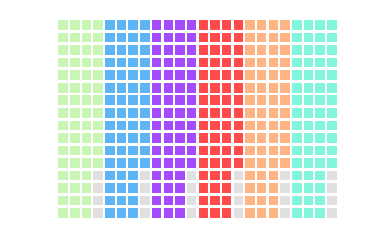

done!


In [186]:
#11/27/18 experiment
#50ul per well
#500nl of inducer=100x
maxinducer=500
wellvol=50
avoidedges=[]#topbottom
wellorder="down"#"across"
shuffle=True
fname = "test.csv"
constructs=["spc3","spc6","spc0a1","spc18b1","spc26c6","spc-18e3"]
inducers=[
    ["SAL",[100,75,50],["K7",4]],
    ["ATC",[100,75,50,0],["K8",4]],
    ["CIN",[100,85,75,50,0],["K9",4]],
]
x=multiD.makeGridWrapper(inducers,constructs,fname,avoidedges,maxinducer,wellvol,shuffle,wellorder=wellorder)


In [ ]:
   #180514 experiment
    atc = [500,250,125,25,0]

    iptg = [500,200,25,0]
    ara = [500,200,25,0]
    cin = [500,200,25,0]
    sal = [500]

    atc2 = [500,200,0]
    iptg2 = [500,0]
    ara2 = [500,0]
    cin2 = [500,0]
    construct = ["A1","E1","I1","M1"]
    constructnames = ["pQi41","pQi51","pQi42","pQi52"]
    inducernames = ["aTC","IPTG","Ara","Cin","Sal"]
    fname = "inductiongrid.csv"
    inducers = [atc,iptg,ara]
    wells = [["H1","I1"],["H2","I2"],["H3","I3"],["H4","I4"],["H5","I5"]]

    blist1 = makeGridFile(inducers,wells,construct,fname,constructnames=constructnames,inducernames=inducernames)
    construct2 = ["D8","L8"]
    construct2names = ["REC24LB","REC24LB"]
    fname = "supinducers1.csv"
    inducers2 = [atc2,iptg2,ara2,cin2,sal]

    #blist = range(80-1)+range(80+17,80+80+17-2)+range(80+80+17+17,80+80+17+17+80-3)
    makeGridFile(inducers2,wells,construct2,fname,blist1,constructnames=construct2names,inducernames=inducernames)

In [ ]:

    #180515 experiment

    inducernames = ["ATC","IPTG","Ara","Cin","Sal"]
    atc = [500,250,25,0]
    iptg = [500,200,25,0]
    ara = [500,200,25,0]
    cin = [500,200,25,0]
    sal = [500]
    construct = ["A1"]#,"I1"]
    fname = "180515-inducers.csv"
    inducers = [atc,iptg,ara,cin,sal]

    constructnames = ["REC24M9"]
    wells = [["H6","I6","J6"],["H7","I7","J7"],["H8","I8","J8"],["H9","I9","J9"],["H10","I10","J10"]]
    makeGridFiles(inducers2,wells,construct2,fname,blist1,constructnames=construct2names,inducernames=inducernames)

In [ ]:
    #180918 experiment
    atc = [500,450,300,250,200,125,50,25,0]
    ara = [500,450,350,275,200,100,50,25,0]
    fname = "181026_atc_ara.csv"
    #the name of the supplementary file generated
    inducernames = ["ATC","Ara"]
    #above is only for the supplementary file
    #below is source wells used for the inducers
    #maximum plate has 384wells*500nl = 192 ul
    #the echo requires 15 ul minimum, and has 55 ul maximum
    #so basically, you get 40 ul per well
    #so to fill the entire plate, you need 5 wells
    #each set of wells below, must be filled with 55 ul of 100x inducer
    wells = [["L21","M21","N21","O21"],\
            #wells for first inducer
             ["H22","I22","J22","K22"], \
             #wells for second inducer
             ]
    #the next line indicates where each well block will start for each construct
    construct = ["A1","G1"]
    #the next line determines how many times you are repeating the grid. each
    #construct is a repeat of the inducer grid
    constructnames = ["rep1","rep2"]
    inducers = [atc,ara]
    blist1 = makeGridFile(inducers,wells,construct,fname,edges,constructnames,inducernames)

In [36]:
#11/19/18 experiment
#50ul per well
#500nl of inducer=100x
maxinducer=500
wellvol=50
avoidedges=False
fname = "181119-spc3_6.csv"
constructs=["spc3","spc6"]
inducers=[
    ["SAL",[100,50,25,10,5],["J1",4]],
    ["ATC",[100,75,50,25,10,0],["J2",4]],
    ["CIN",[100,75,50,25,10,0],["J3",4]],
]




load inducers into: 
SAL : ['J1', 'K1', 'L1', 'M1']
ATC : ['J2', 'K2', 'L2', 'M2']
CIN : ['J3', 'K3', 'L3', 'M3']

make 220.000000 ul of 100x each inducer

constructs start at: 
spc3 : A1
spc6 : I1
prepare 10.56 ml of each construct for 50 well volume
done!


In [12]:
#11/27/18 experiment
#50ul per well
#500nl of inducer=100x
maxinducer=500
wellvol=50
avoidedges=False
shuffle=True
fname = "181127-spc3_6.csv"
constructs=["spc3","spc6"]
inducers=[
    ["SAL",[100,50,25,10,5],["K4",4]],
    ["ATC",[100,75,50,25,10,0],["K5",4]],
    ["CIN",[100,75,50,25,10,0],["K6",4]],
]
x=makeGridWrapper(inducers,constructs,fname,avoidedges,maxinducer,wellvol,shuffle)


load inducers into: 
SAL : ['K4', 'L4', 'M4', 'N4']
ATC : ['K5', 'L5', 'M5', 'N5']
CIN : ['K6', 'L6', 'M6', 'N6']

make 220.000000 ul of 100x each inducer

constructs start at: 
spc3 : A1
spc6 : I1
prepare 10.56 ml of each construct for 50 well volume
done!
